## 批量归一化

* 损失出现在最后，后面出现的层训练较快
* 数据在底部
    * 底部的训练较慢
    * 底部变化会引起整个网络的变化
    * 顶部的层需要重新学习多次
    * 最终导致收敛变慢
* **有没有办法训练底部 并避免变化顶层**

目的：可持续加速深层网络的收敛速度
训练NN时出现的实际问题：
1. 数据预处理的方式通常会对最终结果产生巨大的影响，在使用MLP来预测房价时，使用真实的数据，第一步便是标准化输入特征，使其均值为0，方差为1，这种标准化可以很好地让我们与优化器配合，因为它可以将**参数的量级进行统一**
2. 对于典型的MLP和CNN，当我们训练时，中间层中的变量（例如 MLP的仿射变换输出）可能具有更广的变化范围：不论是沿着从输入到输出的层，跨同一层中的单元，或者随时间的推移，模型参数的训练随着训练更新变幻莫测,BatchNorm的发明者非正式的假设，这些变量分布中的这种偏移可能会阻碍网络的收敛，直观地说，我们可能会猜想吗，如果一个层的可变值是另一层的100倍，这可能需要对学习率进行补偿调整。
3. 更深层的网络很复杂，容易过拟合。这意味着正则化变得更加重要。

BN应用于单个可选层，也可以应用到所有的层，原理如下：在每次迭代中，我们首先规范化输入，即通过减去输入的均值并除以标准差，其中两者均基于当前的小批量处理。 接下来，我们应用比例系数和比例偏移，正是由于这个基于批量统计的标准化，才有了批量规范化的名称。

**只有使用足够大的小批量，批量规范化这种方法才是有效且稳定的。**

在应用BN之后，生成的新的小批量样本具有以下特点:
* 均值为0
* 方差为1

由于单位方差是一个主观的选择，因此我们通常包含拉伸参数（scale）$\lambda$ 和偏移参数(shift)$\beta$,他们的形状与X相同，且他们是需要与其他模型一起学习的参数
由于在训练过程中，中间层的变化幅度不能过于剧烈，而BatchNorm将每一层主动居中，并将他们重新调整为给定的平均值和大小


### 全连接层
通常我们将BN层置于全连接层的仿射变换和激活函数之间
### 卷积层
对于卷积层，我们可以在卷积层之后和非线性激活函数之前应用BN，当卷积有多个输出通道时，我们需要对这些通道的每个输出执行BN，每个通道有自己的Scale和Shift参数，这两个参数都是标量。

## 从0实现

In [1]:
import torch
import torch.nn as nn
import os,sys
sys.path.append(os.path.abspath("../"))
import lmy

/home/anaconda3/envs/lmy/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
tmp = torch.tensor(
    [
        [
            [1, 1, 1],
            [2, 2, 2]
         ],
        [
            [3, 3, 3],
            [4, 4, 4]
         ]
    ]
,dtype=torch.float)
tmp.shape,tmp.mean(dim=(0,1,2),keepdim=True)

(torch.Size([2, 2, 3]), tensor([[[2.5000]]]))

我们需要将数学原理集成到一个自定义的Layer中，用来处理数据，并将其移动到GPU，分配和初始化变量，跟踪移动平均线等。
我们并不担心在这里自动推断输入形状，因此我们需要指定整个特征的数量。

In [3]:
class BatchNorm(nn.Module):
    def __init__(self, num_features, num_dims):
        """初始化BatchNorm类,继承nn.Module类

        Args:
            num_features (int): 特征数量
            num_dims (int): 特征维度
        """
        super().__init__()
        if num_dims == 2:
            shape = (1, num_features)
        elif num_dims == 4:
            shape = (1, num_features, 1, 1)

        # 求参与梯度和迭代的Scale与Shift参数，分别初始化为1和0
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        # 非模型参数的变量初始化0和1
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)

    @staticmethod
    def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
        # 通过is_grad_enable()来判断当前模式是训练模式还是预测模式。
        if not torch.is_grad_enabled():
            # 在预测模式下的计算
            X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
        else:
            # 训练模式
            assert len(X.shape) in (2, 4)
            if len(X.shape) == 2:
                # 当二维表示全连接层上使用 BN
                mean = X.mean(dim=0)  # 计算所有样本的特征均值
                var = ((X - mean) ** 2).mean(dim=0)
            else:
                # 当维数为4 表示在卷积上使用BN
                mean = X.mean(dim=(0, 2, 3), keepdims=True)
                var = ((X - mean) ** 2).mean(dim=(0, 2, 3), keepdims=True)
            # 训练模式下，使用当前均值和方差做标准化
            X_hat = (X - mean) / torch.sqrt(var + eps)
            # 更新移动平均的均值和方差
            moving_mean = momentum * moving_mean + (1.0 - momentum) * mean
            moving_var = momentum * moving_var + (1.0 - momentum) * var
        Y = gamma * X_hat + beta
        return Y, moving_mean.data, moving_var.data

    def forward(self, x):
        # 如果X不在内存上，将moving_mean和moving_var复制到与X相同的显存上
        if self.moving_mean.device != x.device:
            self.moving_mean = self.moving_mean.to(x.device)
            self.moving_var = self.moving_var.to(x.device)
        # 保存更新过的moving_mean和moving_var
        Y, self.moving_mean, self.moving_var = self.batch_norm(
            x, self.gamma, self.beta, self.moving_mean, self.moving_var, eps=1e-5, momentum=0.9)
        return Y

### 使用BN的LeNet

FashionMNIST数据集加载成功，训练集大小:60000,测试集大小:10000,数据集shape:torch.Size([1, 28, 28])
训练设备[device(type='cuda', index=0)]


100%|██████████| 10/10 [00:59<00:00,  5.90s/epoch]

loss:25.902%,train_acc:90.522%,test_acc:83.130%)


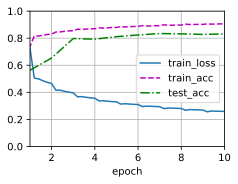

In [6]:
LeNet = nn.Sequential(
    nn.Conv2d(1, 6, 5), BatchNorm(6, 4),nn.Sigmoid(),
    nn.AvgPool2d(2, stride=2),
    nn.Conv2d(6,out_channels=16,kernel_size=5), BatchNorm(16, 4),nn.Sigmoid(),
    nn.AvgPool2d(2, stride=2),nn.Flatten(),
    nn.Linear(16*4*4, 120), BatchNorm(120, num_dims=2), nn.Sigmoid(),
    nn.Linear(120, 84), BatchNorm(84, num_dims=2), nn.Sigmoid(),
    nn.Linear(84, 10)
    )

lr, num_epochs, batch_size = 1.0, 10, 256
train_iter, test_iter = lmy.loadFashionMnistData(batch_size)
lmy.train_GPU(LeNet,train_iter,test_iter,num_epochs=num_epochs,lr=lr)


In [ ]:
LeNet[1].gamma.reshape((-1,)),LeNet[1].beta.reshape((-1,))

(tensor([3.9555, 3.0857, 1.6137, 2.4473, 3.7162, 2.8469],
        grad_fn=<ReshapeAliasBackward0>),
 tensor([-1.6052, -2.1550, -1.0218,  1.7093,  2.2216, -2.9707],
        grad_fn=<ReshapeAliasBackward0>))

### 简洁实现

FashionMNIST数据集加载成功，训练集大小:60000,测试集大小:10000,数据集shape:torch.Size([1, 28, 28])
训练设备[device(type='cuda', index=0)]


100%|██████████| 10/10 [00:54<00:00,  5.49s/epoch]

loss:25.863%,train_acc:90.587%,test_acc:84.980%)


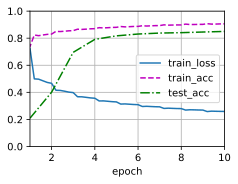

In [5]:
LeNet1 = nn.Sequential(
    nn.Conv2d(1, 6, 5),nn.BatchNorm2d(6), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.BatchNorm2d(16), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(256, 120), nn.BatchNorm1d(120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.BatchNorm1d(84), nn.Sigmoid(),
    nn.Linear(84, 10)
    )

lr, num_epochs, batch_size = 1.0, 10, 256
train_iter, test_iter = lmy.loadFashionMnistData(batch_size)
lmy.train_GPU(LeNet1,train_iter,test_iter,num_epochs=num_epochs,lr=lr)


小码哥家附近的一个主题公园最近搞了一个活动，小码哥在活动中获得了一等奖。
一等奖是一长串的纸条，上面有n个格子，每个格子里有一个数字，活动人员告诉小码哥，只要他裁下一段连续的格子，格子内数字的总和/裁下的格子的数量大于等于门票费t，那么小码哥就能用这段格子抵消门票费小码哥想要尽可能多的利用这个奖品，为此他想先知道有多少种裁剪的方案能裁出一段能 抵消门票费的格子
由于方案数可能很大所以需要你输出方案数对1e9+7取模的结果

In [28]:
# 生成一个字典,每个字母对应一个数字
dict = {
    'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'H': 8, 'I': 9, 'J': 10, 'K': 11, 'L': 12, 'M': 13,
    'N': 14, 'O': 15, 'P': 16, 'Q': 17, 'R': 18, 'S': 19, 'T': 20, 'U': 21, 'V': 22, 'W': 23, 'X': 24, 'Y': 25,
    'Z': 26
}
# 检测是单元格坐标还是系统坐标的形式
def checkType(x):
    # 以RxCx的形式表示
    if x[0] == 'R' and int(x[1]) in range(1, 10):
        return 'RC'
    else:
        return 'XY'
def convert26(x):
    # 将字母转换为数字
    if type(x) == type("a"):
        result = 0
        for i in len(x):
            result += dict[x[i]] * (26 ** (len(x) - i - 1))
        return result
    
def convertRC2XY(x):
    c_index = x.find('C')
    X1 = int(x[1:c_index])
    X2 = int(x[c_index + 1:])
    # print(X1,X2)
    
    print()
    

def convertXY2RC(x):
    pass
def main():
    times = int(input())
    inputs = []
    for _ in times:
        inputs.append(input())
    for x in inputs:
        if checkType(x) == 'RC':
            # 如果是单元格坐标
            convertRC2XY(x)
        else:
            # 如果是系统坐标
            convertXY2RC(x)
print(convert26("A"))

x is str


TypeError: 'int' object is not iterable